In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import configs

device = 'cpu'

In [2]:
trained_dir = '/home/chingf/engram/Ching/'

## Plot loss for different gammas and recurrent steps

In [17]:
# Load the file
with open(f"{trained_dir}02_gamma_v_rsteps/results.p", 'rb') as f:
    results = pickle.load(f)
for key in results.keys():
    results[key] = np.array(results[key])

In [80]:
# Or gather from tfevents manually
gridsearch_dir = f"{trained_dir}02_gamma_v_rsteps/"
gamma_axes = []
rstep_axes = []
vals = []
nonlinearities = []
best_iters = []

for gamma in os.listdir(gridsearch_dir):
    gamma_dir = gridsearch_dir + f'{gamma}/'
    if not os.path.isdir(gamma_dir): continue
    for rstep in os.listdir(gamma_dir):
        rstep_dir = gamma_dir + f'{rstep}/'
        for nonlinearity in os.listdir(rstep_dir):
            nonlinearity_dir = rstep_dir + f'{nonlinearity}/'
            iter_vals = []
            for _iter in os.listdir(nonlinearity_dir):
                iter_dir = nonlinearity_dir + f'{_iter}/'
                for file in os.listdir(iter_dir):
                    if 'tfevents' not in file: continue
                    tfevents_file = iter_dir + file
                    event_acc = EventAccumulator(tfevents_file)
                    event_acc.Reload()
                    try:
                        iter_vals.append(
                            event_acc.Scalars('return_error_M')[-1].value
                            #event_acc.Scalars('loss_train')[-1].value
                            )
                    except:
                        iter_vals.append(np.nan)
            if len(iter_vals) == 0: continue
            val = np.nanmin(iter_vals)
            gamma_axes.append(gamma)
            rstep_axes.append(int(rstep))
            vals.append(val)
            nonlinearities.append(nonlinearity)
            try:
                best_iters.append(np.nanargmin(iter_vals))
            except:
                best_iters.append(0)
gamma_axes = np.array(gamma_axes)
rstep_axes = np.array(rstep_axes)
vals = np.array(vals)
nonlinearities = np.array(nonlinearities)
best_iters = np.array(best_iters)
                
results = {
    'gamma_axes': gamma_axes,
    'rstep_axes': rstep_axes,
    'vals': vals,
    'nonlinearities': nonlinearities,
    'best_iters': best_iters
}

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: All-NaN axis encountered


In [19]:
xs = np.array(results['rstep_axes'])
ys = np.array(results['gamma_axes'])
xs = np.sort(np.unique(xs))
ys = np.sort(np.unique(ys))

None


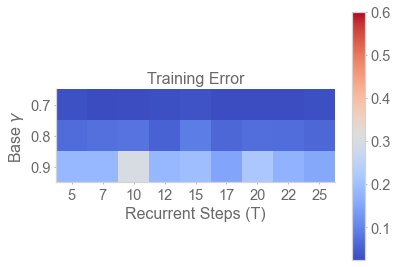

relu


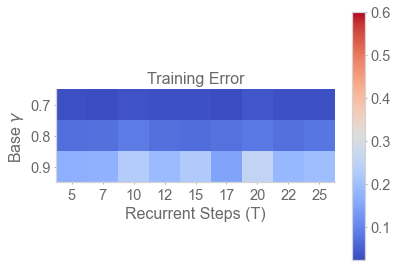

In [22]:
for nonlinearity in np.unique(nonlinearities):
    print(nonlinearity)
    mat = np.zeros((xs.size, ys.size))*np.nan
    _rsteps = results['rstep_axes'][nonlinearities == nonlinearity]
    _gammas = results['gamma_axes'][nonlinearities == nonlinearity]
    _vals = results['vals'][nonlinearities == nonlinearity]
    for rstep, gamma, val in zip(_rsteps, _gammas, _vals):
        x_idx = np.argwhere(xs == rstep)[0,0]
        y_idx = np.argwhere(ys == gamma)[0,0]
        mat[x_idx][y_idx] = val
        
    plt.figure()
    plt.imshow(mat.T, cmap="coolwarm", vmax=0.6)
    plt.yticks(np.arange(ys.size), ys)
    plt.xticks(np.arange(xs.size), xs)
    plt.xlabel('Recurrent Steps (T)')
    plt.ylabel('Base $\gamma$')
    plt.colorbar()
    plt.title("Training Error")
    plt.tight_layout()
    #plt.savefig("gamma_v_rsteps.png", dpi=300)
    plt.show()

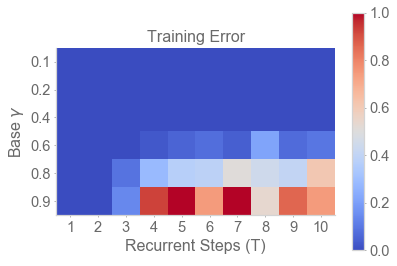

In [18]:
plt.figure()
plt.imshow(mat.T, cmap="coolwarm", vmax=1.)
plt.yticks(np.arange(ys.size), ys)
plt.xticks(np.arange(xs.size), xs)
plt.xlabel('Recurrent Steps (T)')
plt.ylabel('Base $\gamma$')
plt.colorbar()
plt.title("Training Error")
plt.tight_layout()
#plt.savefig("gamma_v_rsteps.png", dpi=300)
plt.show()

## Run test loss for different gammas and recurrent steps

In [3]:
def run(exp_dir):
    num_states = 20

    # Test dataset
    dset = inputs.Sim1DWalk(num_steps=4000, num_states=num_states, left_right_stay_prob=[4,1,1])
    dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)

    with open(exp_dir + 'net_configs.p', 'rb') as f:
        net_configs = pickle.load(f)
    net_configs['num_states'] = num_states

    # Load that model and test
    net = STDP_SR(**net_configs)
    net.load_state_dict(torch.load(exp_dir + 'model.pt'))
    net.set_num_states(num_states)
    with torch.no_grad():
        _, outputs = net(dg_inputs, reset=True)
    
    rnn_T = net.get_T().numpy()
    rnn_M = net.get_M()
    est_T = dset.est_T
    est_M = np.linalg.pinv(
        np.eye(est_T.shape[0]) - net.gamma*est_T
        )
    return np.mean(np.abs(rnn_T - est_T)), np.mean(np.abs(rnn_M - est_M))

In [ ]:
# Or gather from tfevents manually
gridsearch_dir = f"{trained_dir}02_gamma_v_rsteps/"
gamma_axes = []
rstep_axes = []
mean_T_maes = []
mean_M_maes = []
min_T_maes = []
min_M_maes = []
nonlinearities = []

for gamma in os.listdir(gridsearch_dir):
    gamma_dir = gridsearch_dir + f'{gamma}/'
    if not os.path.isdir(gamma_dir): continue
    for rstep in os.listdir(gamma_dir):
        rstep_dir = gamma_dir + f'{rstep}/'
        for nonlinearity in os.listdir(rstep_dir):
            nonlinearity_dir = rstep_dir + f'{nonlinearity}/'
            iter_T_maes = []
            iter_M_maes = []
            for _iter in os.listdir(nonlinearity_dir):
                iter_dir = nonlinearity_dir + f'{_iter}/'
                if not os.path.isfile(iter_dir + 'net_configs.p'):
                    continue
                T_maes = []
                M_maes = []
                for _ in range(3):
                    T_mae, M_mae = run(iter_dir)
                    T_maes.append(T_mae)
                    M_maes.append(M_mae)
                print(M_maes)
                iter_T_maes.append(np.mean(T_maes))
                iter_M_maes.append(np.mean(M_maes))
            if len(iter_T_maes) == 0: continue
            print(nonlinearity)
            print(rstep)
            print(iter_M_maes)
            print()
            nonlinearities.append(nonlinearity)
            gamma_axes.append(gamma)
            rstep_axes.append(int(rstep))
            mean_T_maes.append(np.nanmean(iter_T_maes))
            mean_M_maes.append(np.nanmean(iter_M_maes))
            min_T_maes.append(np.nanmin(iter_T_maes))
            min_M_maes.append(np.nanmin(iter_M_maes))
gamma_axes = np.array(gamma_axes)
rstep_axes = np.array(rstep_axes)
mean_T_maes = np.array(mean_T_maes)
mean_M_maes = np.array(mean_M_maes)
min_T_maes = np.array(min_T_maes)
min_M_maes = np.array(min_M_maes)
nonlinearities = np.array(nonlinearities)
                
results = {
    'gamma_axes': gamma_axes,
    'rstep_axes': rstep_axes,
    'mean_T_maes': mean_T_maes,
    'mean_M_maes': mean_M_maes,
    'min_T_maes': min_T_maes,
    'min_M_maes': min_M_maes,
    'nonlinearities': nonlinearities
}

[0.11666664718913372, 0.1166666471861679, 0.11666664713494333]
[1.150827936166729, 1.7405285777283594, 1.5995972031666235]
[0.27992905891850905, 0.29275537824087927, 0.29300517260398545]
[0.11965617004718138, 0.10997262340764653, 0.09180402353381371]
[0.1621924298476711, 0.21392557275455737, 0.1260960171966083]
None
17
[0.11666664717008164, 1.496984572353904, 0.2885632032544579, 0.10714427232954721, 0.16740467326627892]

[0.40114218592309625, 0.3183616156923917, 0.2884057996111899]
[0.10674642534817419, 0.11971482584531692, 0.06275187616240084]
[0.6060580718729903, 1.4572687824856894, 0.31660704805272033]
[0.24341331805929112, 0.17505162701673307, 0.14247504806557118]
[0.04012078157181336, 0.0403494030945051, 0.06961813929658577]
relu
17
[0.3359698670755593, 0.09640437578529731, 0.7933113008038001, 0.18697999771386511, 0.05002944132096807]

[0.1166666471753124, 0.11666664714696477, 0.1166666471971983]
[1.1410709713197345, 0.8755702448014452, 1.7137248013389905]
[0.27063970258108305, 0.

[0.09609670170957792, 0.08348064519477318, 0.08592891385418173]
[0.5953907034558075, 0.5835644971744456, 0.5786704125105981]
relu
17
[0.7054056195134081, 4.737067422545079, 0.08739739427295456, 0.08850208691951095, 0.5858752043802837]

[0.19506892948582547, 0.6981321791047554, 0.1510268764203993]
[1.2803363663874125, 1.6468446886582517, 0.718849096712735]
[0.1846097728498146, 0.23183559642875118, 0.17450146949713233]
[1.2590029398838773, 1.4665700806023692, 0.6732642250623941]
[0.364777413173464, 0.38658825708746436, 0.34082576427448763]
None
25
[0.34807599500366004, 1.2153433839194665, 0.19698227959189937, 1.1329457485162135, 0.36406381151180534]

[0.17842250540889537, 0.179257626398378, 0.1790922990881376]
[0.1259067600170848, 0.11365208783494926, 0.12412160722037362]
[0.6046582321017294, 0.5512789226586094, 0.7357853869398542]
[0.8427547722969331, 0.6243326273895691, 0.7074500741736378]
[0.07860042666028243, 0.07825137709608272, 0.09760943797651969]
relu
25
[0.17892414363180364, 0.1

[0.2771631500975923, 0.30429337255743594, 0.25487769804004157]
[0.2946097516106805, 0.3129072610011007, 0.30320010838240097]
[0.27525103365720016, 0.2751075326499756, 0.283009267976909]
[0.2267257893453263, 0.22078399188078698, 0.23194867252452403]
[0.20904388888923342, 0.215800048154736, 0.2177089647772962]
relu
25
[0.27877807356502327, 0.3035723736647274, 0.2777892780946949, 0.22648615125021243, 0.2141843006070885]

[0.28497637768931794, 0.7143951714011189, 0.38173472709621026]
[0.7710164614342248, 0.9336270531341277, 1.189969862623854]
[0.5551277859978634, 0.5062873691945716, 0.514431376159098]
[1.4859936982625117, 0.7285317474744706, 1.1469483253269388]
[0.6217318648264144, 0.8051764933552085, 1.3604573810209166]
None
20
[0.46036875872888233, 0.9648711257307355, 0.5252821771171777, 1.120491257021307, 0.9291219130675131]

[0.21225344725362943, 0.19992321309018948, 0.17306602809728433]
[0.32639641147993864, 0.32476033772863566, 0.35107269721208056]


In [ ]:
xs = np.array(results['rstep_axes'])
ys = np.array(results['gamma_axes'])
xs = np.sort(np.unique(xs))
ys = np.sort(np.unique(ys))

In [ ]:
for nonlinearity in np.unique(nonlinearities):
    print(nonlinearity)
    mat = np.zeros((xs.size, ys.size))*np.nan
    _rsteps = results['rstep_axes'][nonlinearities == nonlinearity]
    _gammas = results['gamma_axes'][nonlinearities == nonlinearity]
    _vals = results['min_M_maes'][nonlinearities == nonlinearity]
    for rstep, gamma, val in zip(_rsteps, _gammas, _vals):
        x_idx = np.argwhere(xs == rstep)[0,0]
        y_idx = np.argwhere(ys == gamma)[0,0]
        #if float(gamma) > 0.7: continue
        mat[x_idx][y_idx] = val
        
    plt.figure()
    plt.imshow(mat.T, cmap="Blues_r", vmax=0.5)
    plt.yticks(np.arange(ys.size), ys)
    plt.xticks(np.arange(xs.size), xs)
    plt.xlabel('Recurrent Steps (T)')
    plt.ylabel('Base $\gamma$')
    plt.colorbar()
    plt.title("Training Error")
    plt.tight_layout()
    #plt.savefig("gamma_v_rsteps.png", dpi=300)
    plt.show()

In [ ]:
for gamma in ['0.7', '0.8', '0.9']:
    plt.figure()
    for nonlinearity in np.unique(nonlinearities):
        idx = np.logical_and(
            nonlinearities == nonlinearity,
            results['gamma_axes'] == gamma
            )
        _rsteps = results['rstep_axes'][idx]
        _vals = results['min_M_maes'][idx]
        sort_idxs = np.argsort(_rsteps)
        _rsteps = _rsteps[sort_idxs]
        _vals = _vals[sort_idxs]
        plt.plot(_rsteps, _vals, label=nonlinearity)
    plt.title(f'{gamma}')
    plt.legend()
    plt.show()